# Домашнее задание "Модели авторегрессии условной гетероскедантичности"

### Задание: Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [59]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from math import sqrt

from arch import arch_model

In [60]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Будем использовать ряд monthly-car-sales-in-quebec-1960

In [61]:
car_sales_df = pd.read_csv("Series/monthly-car-sales-in-quebec-1960.csv")

car_sales = car_sales_df.Count

car_sales_df.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


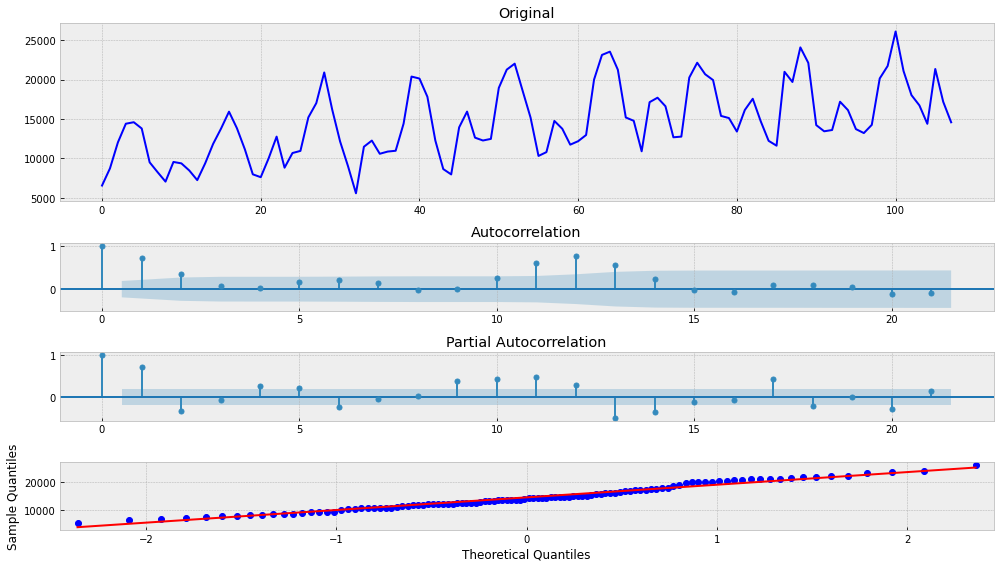

In [62]:
tsplot(car_sales)

По графику хорошо видно тренд и сезонность, насчёт дисперсии визуально сложно сказать. Применим преобразование boxcox, а также уберём сезонность и тренд

In [63]:
car_sales = boxcox(car_sales, 0)
car_sales = car_sales[1:] - car_sales[:-1]
car_sales = car_sales[12:] - car_sales[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -3.516067
p-value                         0.007584
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


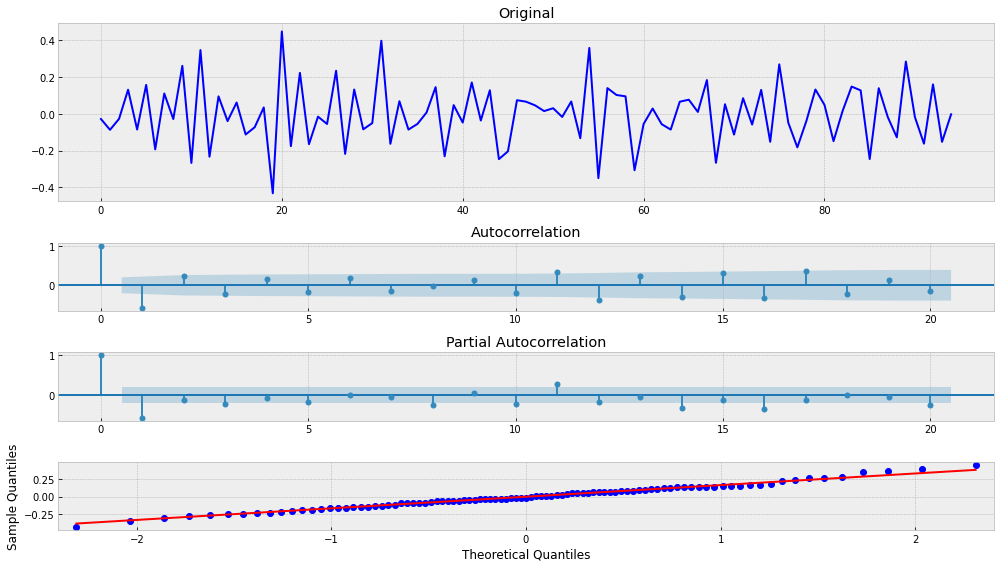

In [64]:
tsplot(car_sales)

Теперь, прежде чем использовать модель GARCH, подберём параметры с помощью ARIMA

In [65]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = sm.tsa.arima.ARIMA(car_sales, order=(i, d, j)).fit()
                tmp_aic = tmp_mdl.aic
                
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

E:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


aic: -118.25851 | order: (4, 0, 3)


In [66]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   95
Model:                 ARIMA(4, 0, 3)   Log Likelihood                  68.129
Date:                Mon, 23 Aug 2021   AIC                           -118.259
Time:                        20:20:59   BIC                            -95.274
Sample:                             0   HQIC                          -108.971
                                 - 95                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.681      0.496      -0.003       0.001
ar.L1         -1.4014      0.160     -8.743      0.000      -1.716      -1.087
ar.L2         -0.2950      0.242     -1.219      0.223      -0.769       0.179
ar.L3          0.4602      0.263      1.747      0.081      -0.056       0.977
ar.L4          0.2130      0.143      1.490      0.136      -0.067       0.493
ma.L1          0.6617     10.139      0.065      0.948     -19.210      20.533
ma.L2         -0.7589     16.855     -0.045      0.964     -33.794      32.276
ma.L3         -0.9024      9.163     -0.098      0.922     -18.861      17.056
sigma2         0.0133      0.134      0.099      0.921      -0.250       0.277
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 6.15
Prob(Q):                              0.78   Prob(JB):                         0.05
Heteroskedasticity (H):               0.71   Skew:                            -0.25
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посмотрим прогноз и остатки ARIMA:

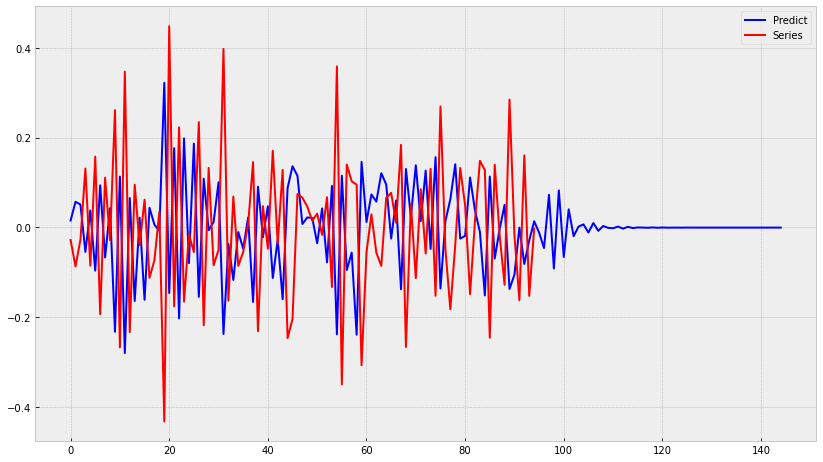

In [67]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    predict = best_mdl.predict(1, len(car_sales)+50, ax=ax)
    plt.plot(predict, color='blue', label='Predict')
    plt.plot(car_sales, color='red', label='Series')
    plt.legend()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.886134e+00
p-value                        3.659937e-17
#Lags Used                     0.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


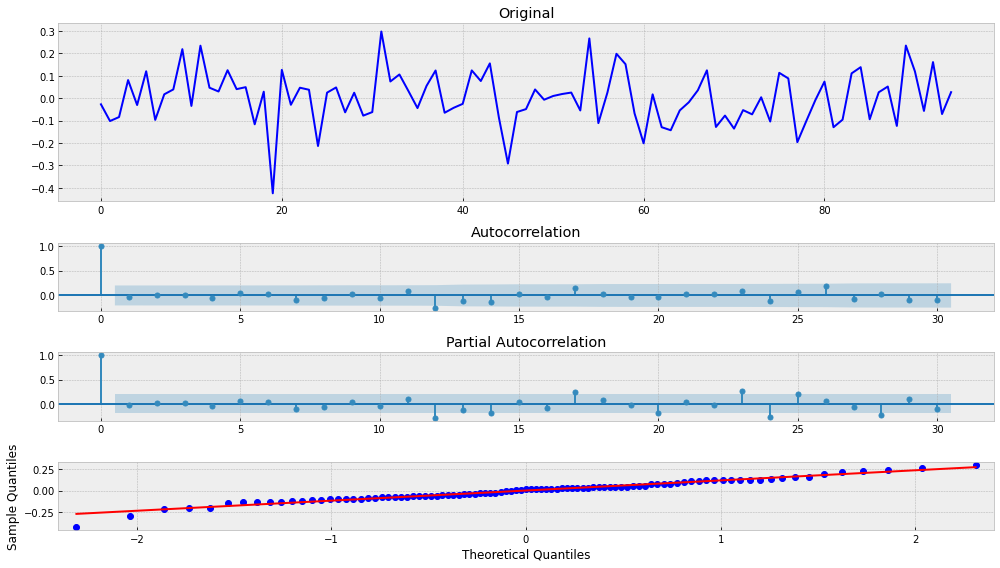

In [68]:
tsplot(best_mdl.resid, lags=30)

А теперь построим модель GARCH, используя гиперпараметры ARIMA:

In [71]:
p_ = 4
o_ = 0
q_ = 3

am = arch_model(car_sales, p=p_, o=o_, q=q_, dist='StudentsT', rescale=False)
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                38.9721
Distribution:      Standardized Student's t   AIC:                          -57.9441
Method:                  Maximum Likelihood   BIC:                          -32.4054
                                              No. Observations:                   95
Date:                      Mon, Aug 23 2021   Df Residuals:                       94
Time:                              20:26:51   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Посмотрим график остатков

Results of Dickey-Fuller Test:
Test Statistic                 -3.516067
p-value                         0.007584
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


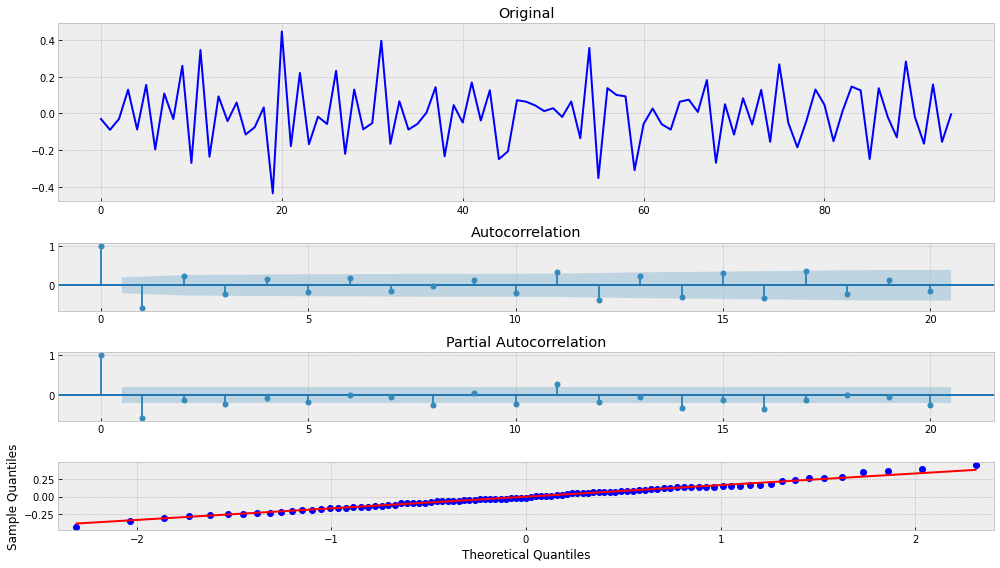

In [70]:
tsplot(res.resid)

И сделаем прогноз дисперсии 

In [93]:
n_test = 20

train, test = car_sales[:-n_test], car_sales[-n_test:]

In [100]:
model = arch_model(train, p=p_, o=o_, q=q_, vol='GARCH', dist='Normal', rescale=True, mean='Zero')

model_fit = model.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 146.4834183428666
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1167.7414496202994
Iteration:      3,   Func. Count:     31,   Neg. LLF: 143.0534561132562
Iteration:      4,   Func. Count:     40,   Neg. LLF: 143.02286266674903
Iteration:      5,   Func. Count:     50,   Neg. LLF: 142.87203752564025
Iteration:      6,   Func. Count:     59,   Neg. LLF: 142.8450266837693
Iteration:      7,   Func. Count:     68,   Neg. LLF: 142.84341855560237
Iteration:      8,   Func. Count:     77,   Neg. LLF: 142.84338180912425
Iteration:      9,   Func. Count:     85,   Neg. LLF: 142.84338183171502
Optimization terminated successfully    (Exit mode 0)
            Current function value: 142.84338180912425
            Iterations: 9
            Function evaluations: 85
            Gradient evaluations: 9


E:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


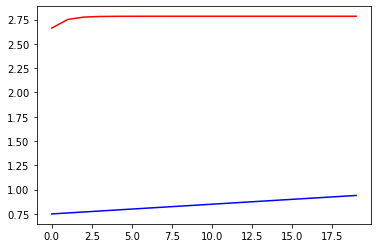

In [101]:
yhat = model_fit.forecast(horizon=n_test)
var = [i*0.01 for i in range(0,95)]

plt.plot(var[-n_test:], color='blue')
plt.plot(yhat.variance.values[-1, :], color='red')
plt.show()

Мне кажется, здесь модель ARIMA показывает лучшие резулдьтаты

<b>Вопрос:</b> эта модель осталась для меня самой непонятной из всех. В отличии от других моделей здесь мы работаем с дисперсией, и я так и не поняла, как эти результаты потом переводить в реальный прогноз ряда? Где можно почитать о применении этой модели на практике?